# 第4章 モデルの訓練
これまでは機械学習モデルや訓練アルゴリズムをブラックボックスとして扱っていたが，この章ではそれらの動作の仕組みを詳しく見ていく．
それによって，適切なモデル・アルゴリズムの選択やハイパーパラメータの設定，問題点のデバッグに役立つ．  
この章では，最初に最も単純なモデルである線形回帰モデルを取り上げ，2つの大きく異なる訓練方法を見ていく．

- 閉形式の方程式を使う方法  
訓練セットに対して最も適合するモデルパラメータを直接計算する．
- 勾配降下法（Gradient Descent）を使う方法  
訓練セットに対してコスト関数が最小になるようモデルパラメータを少しずつ調整し，最終的に閉経式の方程式を使う方法と同じパラメータに収束させる．
ニューラルネットワークではこちらが特に重要となる．

次に，非線形データセットにも適用可能な多項式回帰を取り上げる．
多項式回帰はパラメータ数が多く，線形回帰よりも過学習を起こしやすいので，その判別方法やリスク削減のためのテクニックについて考える．  
最後に，分類回帰でよく用いられるロジスティック回帰とソフトマックス回帰について検討する．

## 4.1 線形回帰
一般に，線形モデルは次式のように入力特徴量の荷重総和に**バイアス項**（bias term, **切片項**: intercept term）を加えたものである．

$$
\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 + \cdots + \theta_nx_n
$$

- $\hat{y}$ : 予測値
- $n$ : 特徴量数
- $x_i$ : i番目の特徴量の値
- $\theta_j$ : j番目のモデルパラメータ

さらに，ベクトル形式で表記することで簡潔に書ける．

$$
\hat{y} = h_\theta (\boldsymbol{x}) = \theta^T \cdot \boldsymbol{x}
$$

- $\theta$ : モデルの**パラメータベクトル** 
- $\theta^T$ : $\theta$ の転置
- $\boldsymbol{x}$ : インスタンスの**特徴量ベクトル**(feature vector)
- $\theta^T \cdot \boldsymbol{x}$ : $\theta^T$ と $\boldsymbol{x}$ のドット積
- $h_\theta$ : モデルパラメータ$\theta$を使った仮設関数

この線形回帰モデルの学習では，回帰モデルの一般的な性能指標である RMSE または MSE を最小にする $\theta$ を見つければ良い．
ここでは，より簡単に結果が得られる MSE の最小化を考える．（RMSE を使っても結果は同じになる）  
訓練セット $\boldsymbol{X}$ にたいする線形回帰仮説 $h_\theta$ の MSE は次式で与えられる．

$$
MSE(\boldsymbol{X}, h_\theta) = \frac{1}{m} \sum_{i=1}^m \left(\theta^T \cdot \boldsymbol{x}^{(i)} - y^{(i)}\right)^2
$$

### 4.1.1 正規方程式
コスト関数を最小にする $\theta$ の値を求める方法として，**閉形式解**（closed-form solution）を求める方法がある．
このような解を与える数学的方程式を**正規方程式**（normal equation）と呼ぶ．

$$
\hat{\theta} = \left(\boldsymbol{X}^T \cdot \boldsymbol{X} \right)^{-1} \cdot \boldsymbol{X}^T \cdot y
$$

- $\hat{\theta}$ : コスト関数を最小にする $\theta$
- $y$ : $y^{1}$ から $y^{m}$ までのターゲット値を格納したベクトル

NumPy で線形に見えるデータを生成し，この方程式を確認してみる．

In [78]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

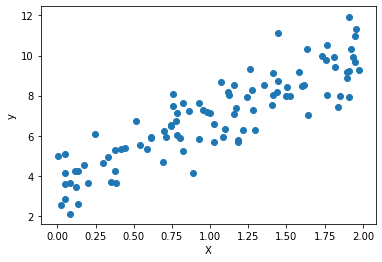

In [6]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [12]:
X_b = np.c_[np.ones((100, 1)), X] # 各インスタンスに x0 = 1 を加える
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.66737033],
       [3.19340502]])

$\theta_0 = 3.67$，$\theta_1 = 3.19$ でそれぞれ正解の4と3に十分近いと言えるが，ノイズのために正確なパラメータを復元することはできない．

In [13]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # 各インスタンスに x0 = 1 を加える
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.66737033],
       [10.05418037]])

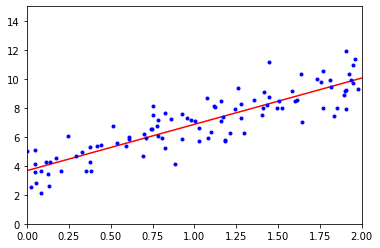

In [14]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

これを scikit-learn で実装すると以下のようになる．

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.66737033]), array([[3.19340502]]))

In [17]:
lin_reg.predict(X_new)

array([[ 3.66737033],
       [10.05418037]])

### 4.1.2 計算量
正規方程式では $n \times n$ の逆行列を計算する必要がある．
その計算量は実装によって異なるが，一般に $O(n^{2.4})$ から $O(n^3)$ であるため，特徴量が多くなると非常に遅くなる．  
しかし，正規方程式は訓練セットのインスタンス数 $m$ に対して線形であり（$O(m)$），大規模な訓練セットでもメモリに収まる限り効率よく処理できる．
また，訓練後の線形回帰モデルの計算量はインスタンス数，特徴量数の両方に対して線形であるため，非常に高速な予測が可能である．

## 4.2 勾配降下法
パラメータを繰り返し操作しコスト関数を最小化する最適化アルゴリズムを**勾配降下法**(Gradient Descent)と呼ぶ．  
パラメータベクトル$\theta$についてコスト関数の局所的な勾配を測定し，下降方向にパラメータベクトルを変化させることで，勾配が0になる最小値を求めることができる．
**ランダム初期化**(random initialization)によって適当な値で$\theta$を初期化し，コスト関数が小さくなるように小さなステップでパラメータを動かすことを，最小値に**収束**(converge)するまで繰り返す．

<img src="img/ch03/p113.png">

勾配降下法では各ステップのサイズを決めるハイパーパラメータである**学習率**(Learning Rate)を適切に設定する必要がある．
学習率の設定が小さすぎると収束までの反復回数が増えて時間がかかることになり，逆に大きすぎるとアルゴリズムが発散してしまい良いソリューションが発見できなる．  
また，**局所的な最小値**へ収束する場合や，台地で停滞してしまう場合には，**全体の最小値**に収束しないこともある．

<img src="img/ch03/p114.png">

先程紹介した MSE コスト関数は**凸関数**(Convex Function)かつ連続関数であるため，学習率の設定が適切で十分時間をかければ最小値に収束することが保証される．  
このように，**パラメータ空間**(Parameter Space)を探索し，コスト関数が最小になるようなモデルパラメータの組み合わせを探索する．

### 4.2.1 バッチ勾配降下法
勾配降下法を実装するためには，次式のように個々のモデルパラメータ$\theta_j$についてコスト関数を**偏微分**(Partial Derivative)して勾配を計算する．

$$
\frac{\partial}{\partial\theta_j}MSE(\theta) = \frac{2}{m}\sum_{i=1}^m\left(\theta^T\cdot\boldsymbol{x}^{(i)} - y^{(i)}\right)x_j^{(i)}
$$

このように偏微分を個別に計算しなくても，次式によってまとめて計算できる．

$$
\nabla_\theta MSE(\theta) = 
\begin{pmatrix}
\frac{\partial}{\partial\theta_0}MSE(\theta) \\
\frac{\partial}{\partial\theta_1}MSE(\theta) \\
\vdots \\
\frac{\partial}{\partial\theta_n}MSE(\theta)
\end{pmatrix}
= \frac{2}{m}\boldsymbol{X}^T\cdot\left(\boldsymbol{X}\cdot\theta-\boldsymbol{y}\right)
$$

勾配ベクトルが計算できた，その勾配ベクトルと逆方向にパラメータを動かす．
すなわち，学習率を$\eta$として次式によってパラメータを更新する．

$$
\theta^{(next step)} = \theta - \eta\nabla_\theta MSE(\theta)
$$

このアルゴリズムの実装は次のとおりである．

In [35]:
def gradient_descent(X, y, lr, n_iter=1000):
    # 適当に初期値を決める
    theta = np.random.randn(2, 1)

    for iteration in range(n_iter):
        gradients = X.T.dot(X.dot(theta) - y) * 2 / len(X)
        theta = theta - lr * gradients
        
    print("(lr, n_iter) = ({}, {}) -> theta =".format(lr, n_iter), theta.T[0])
    
    
gradient_descent(X_b, y, 0.5)
gradient_descent(X_b, y, 0.1)
gradient_descent(X_b, y, 0.001)

(lr, n_iter) = (0.5, 1000) -> theta = [-1.43499349e+100 -1.75561365e+100]
(lr, n_iter) = (0.1, 1000) -> theta = [3.66737033 3.19340502]
(lr, n_iter) = (0.001, 1000) -> theta = [2.91582905 3.76575326]


学習率が0.1の場合には正規方程式から導いた解と同じものが得られているが，大きすぎると(0.5)発散してしまい，小さすぎると(0.001)十分に収束しないことが分かる．  
最適な学習率を求めるために，しばしばグリッドサーチが使われる．
最初に反復回数を非常に設定しておき，勾配ベクトルが十分小さくなったら，つまり勾配ベクトルのノルムが許容誤差よりも小さくなったら反復を中止させると良い．

### 4.2.2 確率的勾配降下法
バッチ勾配降下法は，各ステップで全ての訓練セットを使うため，訓練セットが大きくなると計算速度が極端に遅くなってしまうという欠点がある．
そこで，**確率的勾配降下法**(Stochastic Gradient Descent: SGD)は各ステップで訓練セットから無作為に1つのインスタンスを選び出し，そのインスタンスのみを使って勾配を計算する．  
確率的勾配降下法はバッチ勾配降下法に比べて非常に高速で，巨大な訓練セットでも訓練可能である．
一方で，確率的に(無作為に)インスタンスを選び出しているため，単調にコスト関数の最小値まで緩やかに小さくなるのではなく，上下に動きながら平均的に最小値に向かって収束していく．
また，十分回数反復すれば最小値に十分近づき，良いパラメータは得られるが，最適なパラメータではない．  
このような不規則な動きは，局所的な最小値に陥ることを防ぐのに有効であるが，半らいの最小値に落ち着かない可能性を生じる．
そこで，最初は学習率を大きく設定し，徐々に小さくしていくという方法が取られる．
これを**焼きなまし法**(Simulated Annealing)と呼び，各ステップでの学習率を決定する関数を**学習スケジュール**(Learning Schedule)と呼ぶ．
学習率を急速に小さくすると局所的な最小値に陥ったり，最小値に到達しないうちに止まってしまう可能性がある．
一方で，下げ方を緩やかにしすぎると最小値の周辺を動き回ってなかなか最小値に収束しない．  
次のコードは，確率的勾配降下法の実装である．

In [37]:
n_epochs = 50
t0 = 5
t1 = 50
m = len(X_b)

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[3.6549661 ],
       [3.22172661]])

m回のイテレーションを1ラウンドとして，各ラウンドのことを**エポック**(epoch)と呼ぶ．
バッチ勾配降下法で訓練セット全体について1000回反復を行ったのに対して，確率的勾配降下法では50回の処理で十分良い回にたどり着いている．  
インスタンスの選択は無作為なので，あるインスタンスが複数回選ばれる一方で，他のインスタンスが全く選ばれないこともある．
全てのインスタンスを処理するために，訓練セットをシャッフルしてからインスタンスを逐次取り出しても良いが，この方法は一般に収束するまで余計に時間がかかる．  
scikit-learn では，デフォルトで二乗誤差を使って最適化を行う，SGDRegressor クラスを使う．

In [43]:
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([3.68448907]), array([3.22370692]))

### 4.2.3 ミニバッチ勾配降下法
**ミニバッチ勾配降下法**(Mini-batch Gradient Descent)は，**ミニバッチ**(mini-batch)と呼ばれる無作為に選んだインスタンスの小さな集合を用いて勾配の計算を行う．
ミニバッチ勾配降下法の利点としては，GPU使用時に行列演算用のハードウェアによる最適化を利用することでパフォーマンスを向上させられることが挙げられる．  
パラメータ空間におけるこのアルゴリズムの進み方は，特にかなり大規模なミニバッチを使うと，SGD よりも誤差が小さくなる．
そのため，SGD よりも少し最小値に近いところを動き回るが，局所的な最小値からは逃れにくくなる．  
最後に，これまで見てきたアルゴリズムをまとめておく．

|アルゴリズム|大きなm|アウトオブコア|大きなn|ハイパラ数|スケーリング|scikit-learn|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|正規方程式|速い|×|遅い|0|不要|LinearRegression|
|バッチ GD|遅い|×|速い|2|必要|なし|
|確率的 GD|速い|○|速い|2以上|必要|SGDRegression|
|ミニバッチ GD|速い|○|速い|2以上|必要|SGDRegression|

## 4.3 多項式回帰
非線形なデータに対しても，線形モデルを適用することができる．
最も簡単な方法は，各特徴量の累乗を新しい特徴量として追加し，線形モデルを訓練する方法である．
これを**多項式回帰**(Polynomial Regression)と呼ぶ．  
はじめに単純な**2次方程式**(Quadratic Equation)から非線形データを生成する．

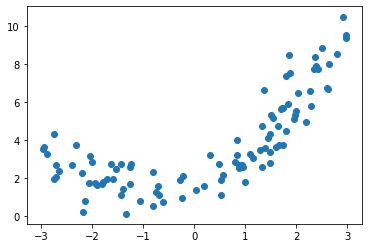

In [44]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 +np.random.randn(m, 1)
plt.scatter(X, y)
plt.show()

In [46]:
# PolynomialFeatures クラスを使って各特徴量の2乗を新しい特徴量として訓練セットに追加
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([2.97055874]), array([2.97055874, 8.8242192 ]))

In [47]:
# LinearRegreassion モデルを適用する
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.74904094]), array([[0.99083011, 0.54581667]]))

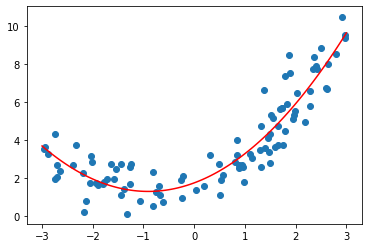

In [49]:
x_linspace = np.linspace(-3, 3, 100)
y_linspace = lin_reg.coef_[0, 1] * x_linspace ** 2 + lin_reg.coef_[0, 0] * x_linspace + lin_reg.intercept_[0]
plt.scatter(X, y)
plt.plot(x_linspace, y_linspace, 'r-')
plt.show()

複数の特徴量があるとき，多項式回帰では特徴量間の関係を見つけることができる．
これは，a と b の2つの特徴量があり degree=2 を指定したとき，$a^2$や$b^2$だけではなく$ab$ のような特徴量も追加されるためである．

## 4.4 学習曲線
より高次元の多項式回帰を行うことで，訓練データによりピッタリと適合させることができる．
しかし，あまり高次元にしてしまうとモデルが過学習を起こして，正確な予測ができない．
また，逆に多項式の次元が低すぎると過小適合となってしまう．
先程の例では，サンプルが2次方程式から生成されていたので，2次元多項式回帰を適用すればよかったが，一般にモデルをどこまで複雑にすれば良いかは自明ではない．  
それを確認する手法として交差検証を用いても良いが，ここでは**学習曲線**(learning curve)に注目する．
学習曲線は訓練セットのサイズの関数として訓練セット(あるいは訓練イテレーション)と検証セットの性能をプロットし
たものである．
プロットは訓練セットのさまざまなサイズのサブセットを使って繰り返しモデルを訓練して描画する．  
次のコードは，訓練セットを与えるとモデルの学習曲線を描く関数を定義する．

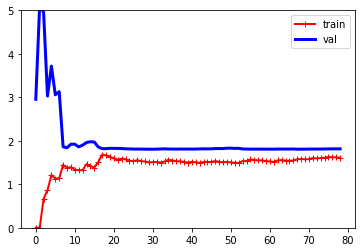

In [62]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.ylim(0, 5)
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

訓練データに対する性能に注目する．
訓練セットのインスタンスが少数なら，モデルはそれらの完全に適合できる．
そのため，訓練セットの線は0からスタートしている．
しかし，訓練セットに新しいインスタンスが追加されると，データにノイズが入っていたり，そもそも線形ではな買ったりと行った理由で，次第にモデルは訓練データに完全に適合することができなくなるため，訓練誤差は次第に上がってある地点で安定する．
そこまで達すると訓練データに新しいインスタンスを追加しても平均誤差はよくも悪くもならない．  
次に，検証セットを見てみると，ごくわずかな訓練セットで訓練されたモデルでは十分に汎化できないため、最初のうちは検証誤差はかなり大きい．
しかし，モデルに与える訓練データの数が増えると，モデルは学習し検証誤差はゆっくりと下がってくる．
しかし，直線ではデータを十分モデリングできなくなると誤差は増減しなくなり，もう一方の曲線と非常に近くなる．
このような学習曲線は過小適合モデルの典型的な例である．
両方の曲線が一定の水準に達し，ともに非常に近接しているが，全体として誤差が大きい．

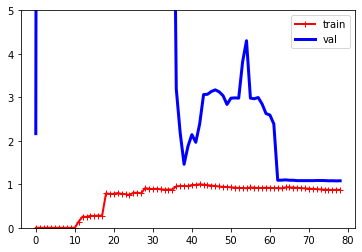

In [64]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)

上のグラフは10次の多項式回帰を行った場合の学習曲線である．
大まかな傾向は過小適合の場合と似ているが，次の点で異なる．

- 線形回帰モデルよりも訓練誤差がかなり小さい
- 2つの曲線の間に大きな差がある  
つまり訓練セットに対する性能のほうがかなり高く，これは過学習で顕著に見られる傾向である．

## 4.5 正則化された線形回帰
正則化はモデルに対する制約を付加することで，過学習を抑える方法である．
線形回帰の正則化では，一般にモデルの重みを制限することで実現している．

### 4.5.1 リッジ回帰 (Ridge Regression)
リッジ回帰は**正則化項**(regularization term)として，コスト関数に $\alpha\sum_{i=1}^n\theta_i^2$ を加える．
すると，データへ適合するだけではなく，モデルの重みを可能な限り小さくする必要がある．
ここで，$\alpha$ はハイパーパラメータで，大きくするとほとんどのパラメータが0でデータの平均値を通る水平線に近づく．  
リッジ回帰のコスト関数は次式で与えられる．
バイアス項 $\theta_0$ は正則化に含めないことに注意する．

$$
J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^n\theta_i^2
$$

下の図は異なる $\alpha$ を用いて訓練したリッジモデルを複数並べたものである．
左側が単純な線形回帰モデル，右側が多項式回帰モデルである．
$\alpha$ を大きくすると予測が平板化され，モデルの分散が下がる一方でバイアスは上がる．

<img src="img/ch03/p130.png">

リッジ回帰の閉形式の解は次式で与えられる．
$\boldsymbol{A}$はバイアス項に対応する左上のセルが0になっている以外は，$n \times n$の**単位行列**(identity matrix)である．

$$
\hat{\theta} = \left(\boldsymbol{X}^T \cdot \boldsymbol{X} + \alpha\boldsymbol{A} \right)^{-1} \cdot \boldsymbol{X}^T \cdot y
$$

scikit-learn で閉形式の解を使ってリッジ回帰を行う．
(正確にはアンドレ・ルイ・コレスキーの行列分解テクニックを使った上式の変種)

In [68]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

SGDRegressor の引数に penalty を設定できる．
ここで，penalty を l2 に設定すると，重みベクトルの L2 ノルムの2乗の半分をコスト関数に加える．
これはまさしくリッジ回帰である．

In [71]:
# 確率的勾配降下法
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.46820908])

### 4.5.2 Lasso 回帰 (Least Absolute Shrinkage and Selection Operator Regression)
Lasso 回帰では正則化項として重みベクトルの L1 ノルムを用いる．

$$
J(\theta) = MSE(\theta) + \alpha\sum_{i=1}^n|\theta_i|
$$

下の図は，単純な線形回帰モデルと多項式回帰モデルに Lass 回帰を適用した例である．
Lasso 回帰では重要性の低い特徴量の重みは0になる傾向がある．
つまり，自動的に特徴量を選択し，**疎なモデル**(Sparse Model: 殆どの特徴量の重みが0となるモデル)を出力する性質を持つ．

<img src="img/ch03/p131.png">

<img src="img/ch03/p132.png">

左上のグラフで、背景の等高線(楕円)は正則化されていない MSE コスト関数を表しており，白い点の連続はそのコスト関数によるバッチ勾配降下法のパスを示している．
前面に描かれている等高線(菱形)は l1 ペナルティを表しており，三角形の連続はこのペナルティのみ(α→∞)のバッチ勾配降下法パスを示している．
パスがまず $\theta_1 = 0$ に達してから $\theta_2 = 0$ にたどり着くまで溝を下っていくことに注意して見る．
右上のグラフでは等高線は同じコスト関数に α=0.5 の l1 ペナルティを加えたものを表している．
全体の最小値は $\theta_2 = 0$ の軸にある．
バッチ勾配降下法は最初に $\theta_2 = 0$ に達してから，全体の最小値に達するまで溝を下っていく．
下のふたつのグラフは，l1 ペナルティではなく l2 ペナルティを使った同じものを示している．
正則化された最小値は正則化されていない最小値よりも $\theta=0$ に近いが，重みは完全に取り除かれていない．

Lasso コスト関数は，$\theta_i = 0$ で微分可能でないが，**劣勾配ベクトル**(subgradient vector)を用いることで次式のように勾配降下法を実現できる．

$$
g(\theta, J) = \nabla_\theta MSE(\theta) + \alpha
\left(
\begin{array}{ccccc}
sign(\theta_1)\\
sign(\theta_2)\\
\vdots\\
sign(\theta_n)
\end{array}
\right)
\quad where \quad sign(\theta_n)=
\left\{
\begin{array}{ll}
-1 & if \quad \theta_i < 0 \\
0 & if \quad \theta_i = 0 \\
+1 & if \quad \theta_i > 0 \\
\end{array}
\right.
$$

In [73]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### 4.5.3 Elastic Net
Elastic Net は，リッジ回帰と Rasso 回帰の中間であり，次の式で与えられる．

$$
J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^n|\theta_i| + \frac{1-r}{2}\alpha\sum_{i=1}^n\theta_i^2
$$

リッジはよいデフォルトになるが，意味がある特徴量は一部だけなのではないかと疑われるときには，役に立たない特徴量の重みを0に引き下げてくれる Lasso や Elastic Net を使った方がよい．
そして，Lasso は訓練インスタンスの数よりも特徴量の数が多いときや，複数の特徴量の間に強い相関があるときに不規則な動きを示すことがあるので，一般にLasso よりも Elastic Net の方がよい．

In [75]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 4.5.4 早期打ち切り(Early Stopping)
正則化項を加える以外の正則化方法として，検証誤差が最小値に達したところで訓練を中止する方法を，早期打ち切りと呼ぶ．
エポックが増えると訓練セットや検証セットに対する予測誤差は小さくなっていく．
しかし，ある程度学習が進むと検証データに対する予測誤差は下げ止まり，むしろ上昇していく．
これは，モデルが訓練データに過学習し始めたことを示している．
そこで，検証誤差が最小になったところで訓練を中止するのが早期打ち切りである．

<img src="img/ch03/p134.png">

fit() メソッドを呼び出したときに warm_start=True になっていると，fit() は訓練を最初からやり直すのではなく，前回の訓練後の状態から訓練を続けることに注意．

In [88]:
# データの準備
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

gd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceW

/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/yuko/.python37-venv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceW

In [89]:
best_epoch, best_model

(9,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=True))

## 4.6 ロジスティック回帰